## РК2 ТМО
### ИУ5-65Б Большаков Г.Н.
### Вариант 3

**Задание**

Для заданного набора данных (по Вашему варианту) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (по варианту для Вашей группы). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

Методы по варианту:
- Метод опорных векторов	
- Градиентный бустинг

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import NotFittedError
from sklearn.metrics import  mean_absolute_error, median_absolute_error, r2_score, root_mean_squared_error
%matplotlib inline 
sns.set(style="ticks")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [76]:
def test_model(model, X_test=None, y_test=None, X_train=None, y_train=None):
    try:
        check_is_fitted(model)
    except NotFittedError:
        if X_train is None or y_train is None:
            raise ValueError("Training data X_train and y_train must be provided if the model is not fitted.")
        model.fit(X_train, y_train)
    
    if X_test is not None and y_test is not None:
        print(model)
        print("mean_absolute_error:", mean_absolute_error(y_test, model.predict(X_test)))
        print("median_absolute_error:", median_absolute_error(y_test, model.predict(X_test)))
        print("root_mean_squared_error:", root_mean_squared_error(y_test, model.predict(X_test)))
        print("r2_score:", r2_score(y_test, model.predict(X_test)))
        print("---------------------------------------")
    else:
        print("Model is fitted, but no test data provided for evaluation.")

In [77]:
data = pd.read_csv('HousingData.csv', sep=',')

In [78]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [80]:
data.shape

(506, 14)

In [81]:
data = data.drop_duplicates()

In [82]:
data.shape

(506, 14)

In [83]:
data.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

Колонка CRIM. Тип данных float64. Количество пустых значений 20, 3.95%.


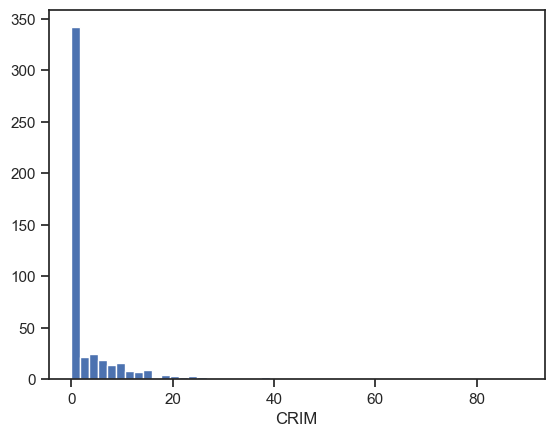

Колонка ZN. Тип данных float64. Количество пустых значений 20, 3.95%.


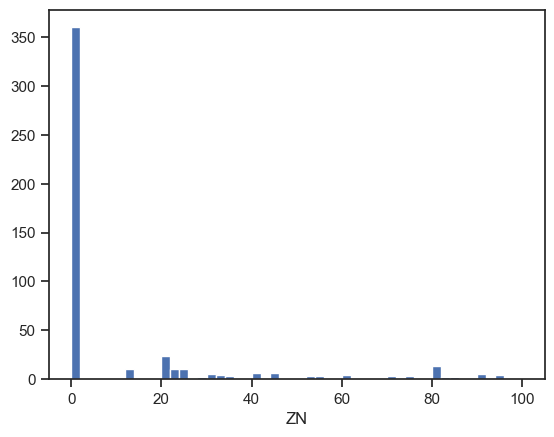

Колонка INDUS. Тип данных float64. Количество пустых значений 20, 3.95%.


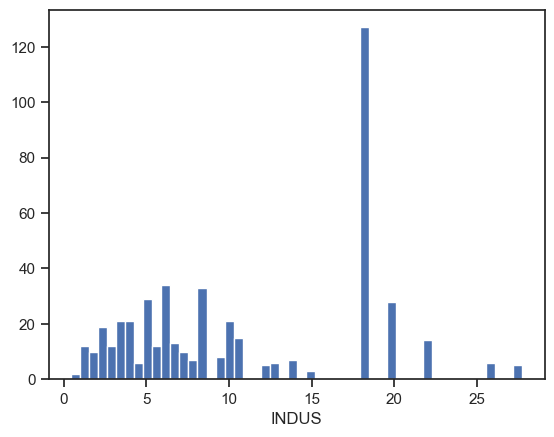

Колонка CHAS. Тип данных float64. Количество пустых значений 20, 3.95%.


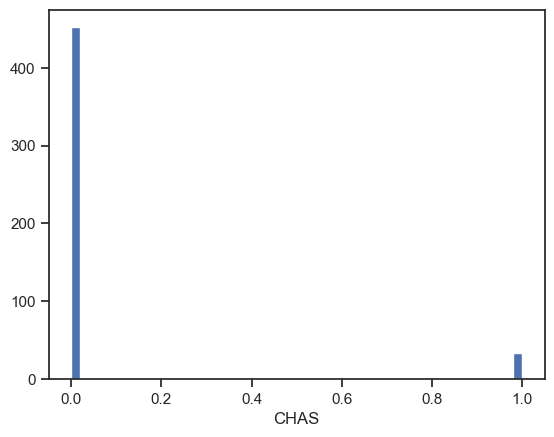

Колонка AGE. Тип данных float64. Количество пустых значений 20, 3.95%.


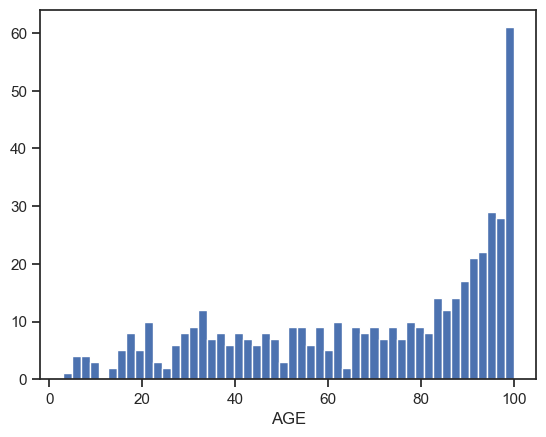

Колонка LSTAT. Тип данных float64. Количество пустых значений 20, 3.95%.


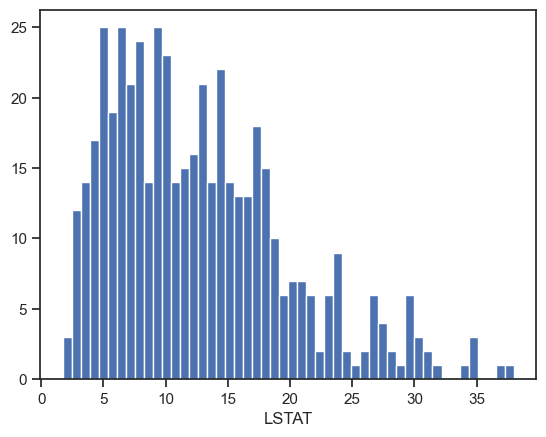

In [84]:
null_cols = []
for col in data.columns:
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        null_cols.append(col)
        temp_perc = round((temp_null_count / data.shape[0]) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(
            col, dt, temp_null_count, temp_perc))
        plt.hist(data[col], 50)
        plt.xlabel(col)
        plt.show()

In [85]:
def random_forest_impute(data, column, is_classification=False):
    df = data.copy()
    
    known = df[df[column].notna()]
    unknown = df[df[column].isna()]
    
    if unknown.empty:
        return df
    
    X_known = known.drop(column, axis=1)
    y_known = known[column]
    
    X_unknown = unknown.drop(column, axis=1)
    
    if is_classification:
        model = RandomForestClassifier()
    else:
        model = RandomForestRegressor()
    
    model.fit(X_known, y_known)
    
    predicted_values = model.predict(X_unknown)
    
    df.loc[df[column].isna(), column] = predicted_values
    
    return df

data_imputed = data.copy()
for col in null_cols:
    if data_imputed[col].dtype == 'object' or len(data_imputed[col].unique()) <= 20:
        data_imputed = random_forest_impute(data_imputed, col, is_classification=True)
    else:
        data_imputed = random_forest_impute(data_imputed, col, is_classification=False)

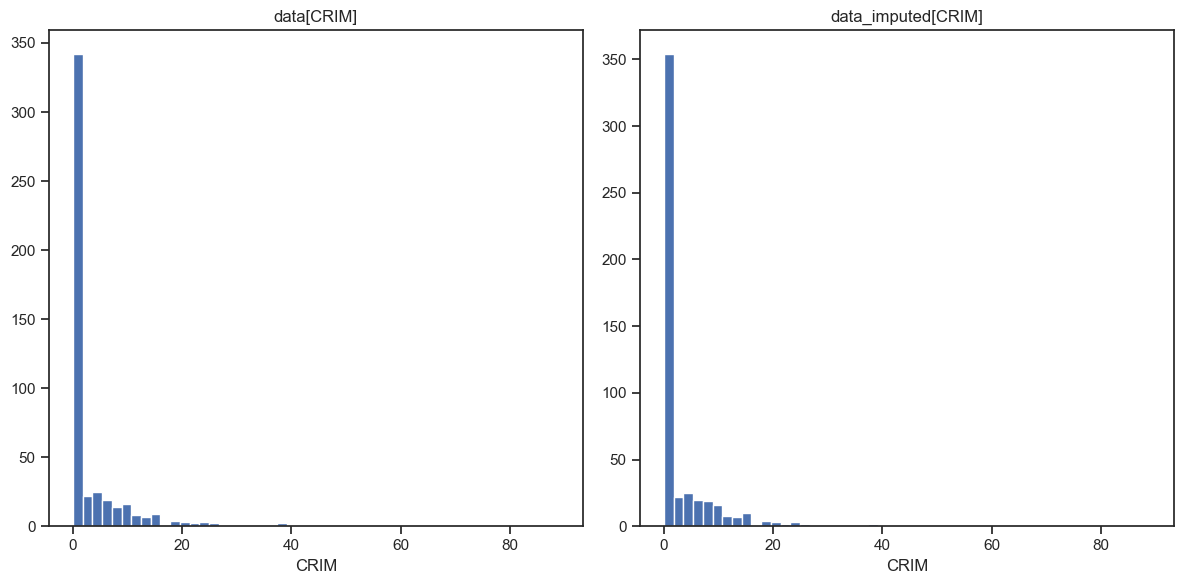

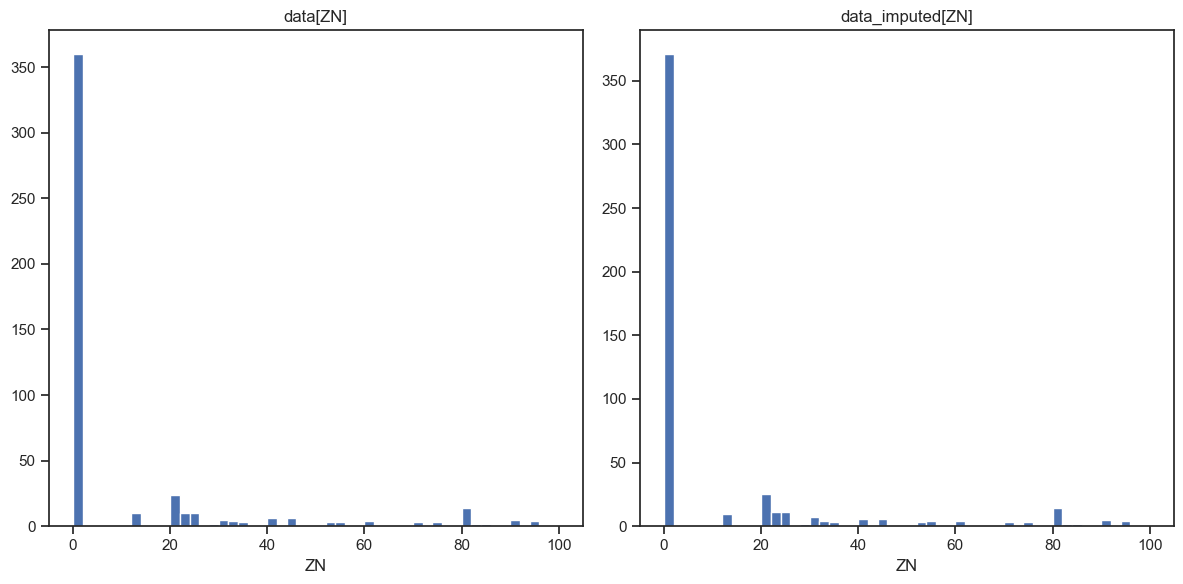

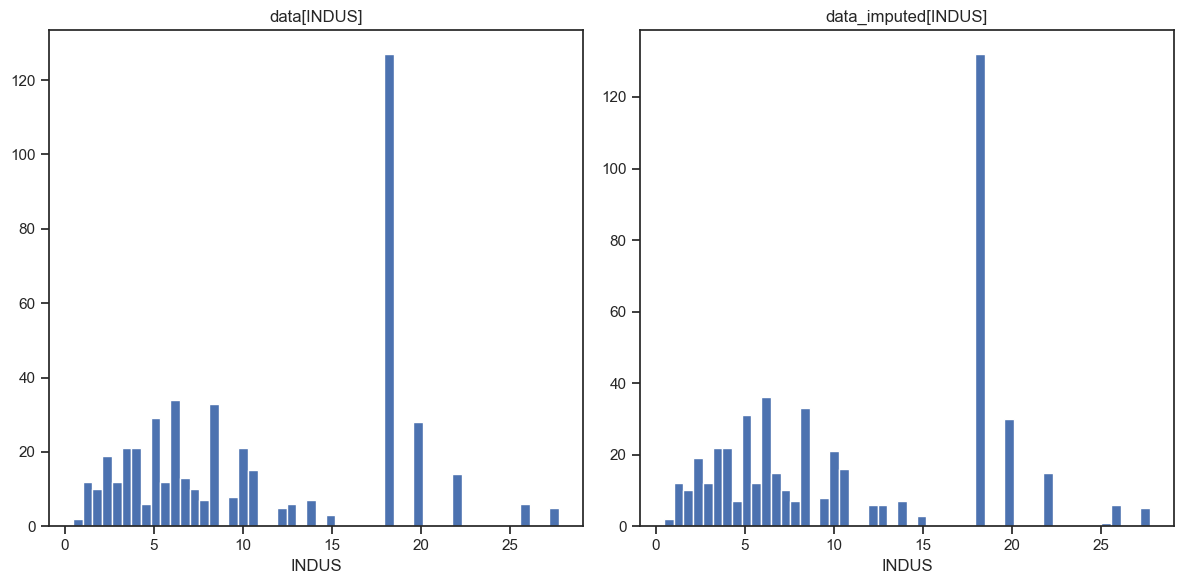

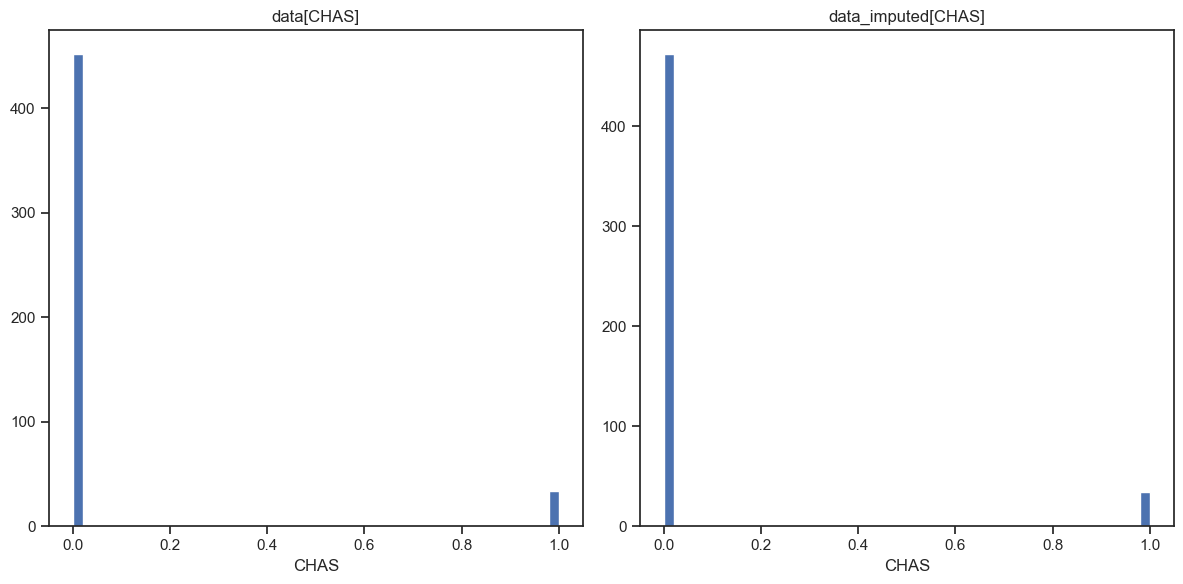

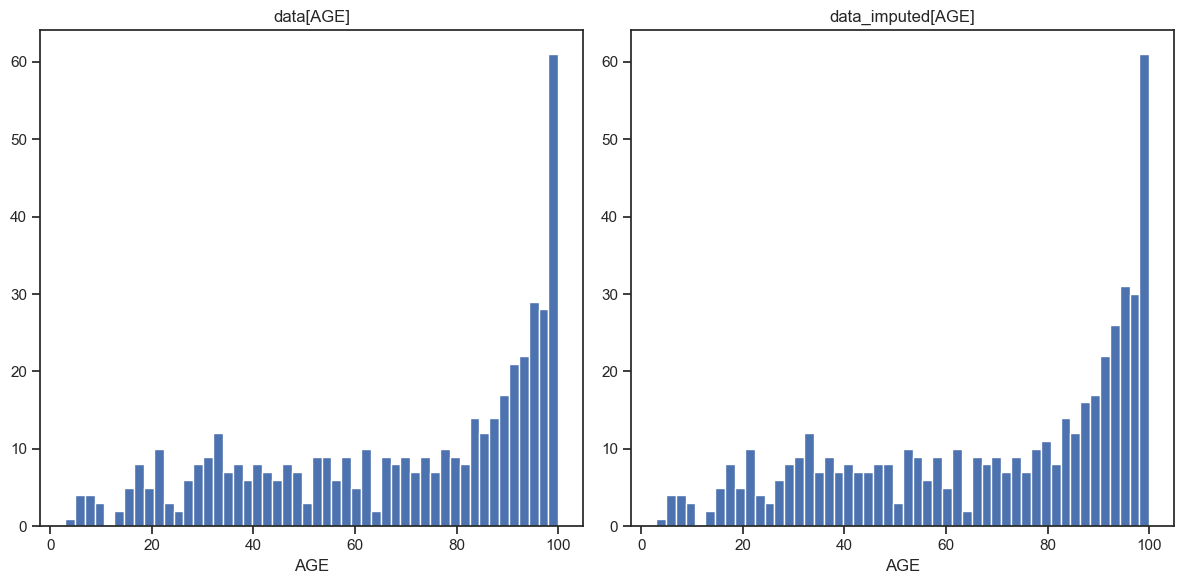

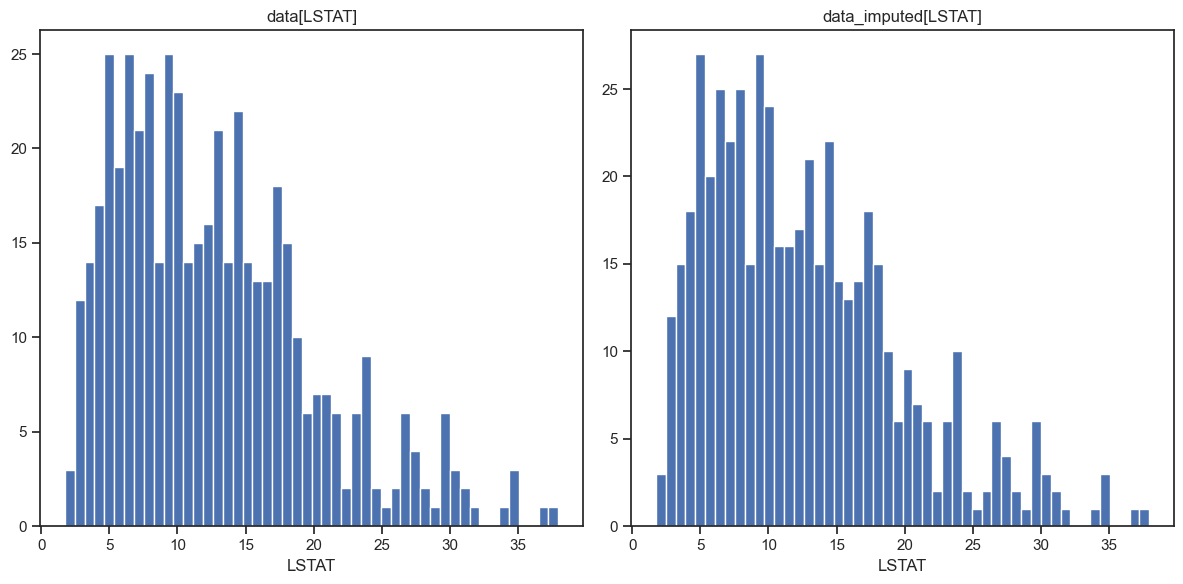

In [86]:
for col in null_cols:    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    axs[0].hist(data[col], bins=50)
    axs[0].set_xlabel(col)
    axs[0].set_title(f'data[{col}]')
    
    axs[1].hist(data_imputed[col], bins=50)
    axs[1].set_xlabel(col)
    axs[1].set_title(f'data_imputed[{col}]')
    
    plt.tight_layout()
    plt.show()

array([[<Axes: title={'center': 'CRIM'}>, <Axes: title={'center': 'ZN'}>,
        <Axes: title={'center': 'INDUS'}>,
        <Axes: title={'center': 'CHAS'}>],
       [<Axes: title={'center': 'NOX'}>, <Axes: title={'center': 'RM'}>,
        <Axes: title={'center': 'AGE'}>, <Axes: title={'center': 'DIS'}>],
       [<Axes: title={'center': 'RAD'}>, <Axes: title={'center': 'TAX'}>,
        <Axes: title={'center': 'PTRATIO'}>,
        <Axes: title={'center': 'B'}>],
       [<Axes: title={'center': 'LSTAT'}>,
        <Axes: title={'center': 'MEDV'}>, <Axes: >, <Axes: >]],
      dtype=object)

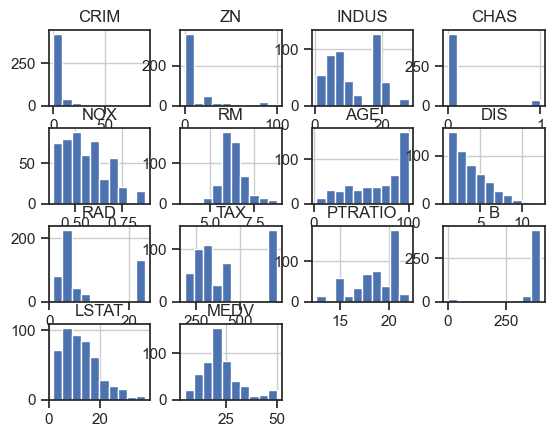

In [87]:
data.hist()

In [88]:
data_X = data_imputed.drop(columns='MEDV')
data_y = data_imputed['MEDV']

In [89]:
scaler = StandardScaler()

data_X_std = scaler.fit_transform(data_X)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(data_X_std, data_y, test_size=0.2, random_state=1)

In [91]:
svr = SVR()
svr.fit(X_train, y_train)
test_model(svr, X_test=X_test, y_test=y_test)

SVR()
mean_absolute_error: 3.5105734544603506
median_absolute_error: 2.110809428734613
root_mean_squared_error: 5.86230948121423
r2_score: 0.6522555878550239
---------------------------------------


In [20]:
param_grid = {
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'C':[1e-3, 1e-2, 10, 1e2, 1e3]
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5)
grid_search.fit(data_X, data_y)
grid_search.best_params_

{'C': 10, 'kernel': 'linear'}

In [100]:
svr_1 = SVR(kernel=grid_search.best_params_['kernel'], C=grid_search.best_params_['C'])
svr_1.fit(X_train, y_train)
test_model(svr_1, X_test=X_test, y_test=y_test)

SVR(C=10, kernel='linear')
mean_absolute_error: 3.414980902547906
median_absolute_error: 2.435957219849719
root_mean_squared_error: 4.807649045178313
r2_score: 0.7661226359758129
---------------------------------------


In [94]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

In [95]:
gb_reg = GradientBoostingRegressor(random_state=1)
gb_reg.fit(X_train, y_train)
test_model(gb_reg, X_test=X_test, y_test=y_test)

GradientBoostingRegressor(random_state=1)
mean_absolute_error: 2.192555853798415
median_absolute_error: 1.6961866811533746
root_mean_squared_error: 2.845533653369505
r2_score: 0.9180686465943974
---------------------------------------


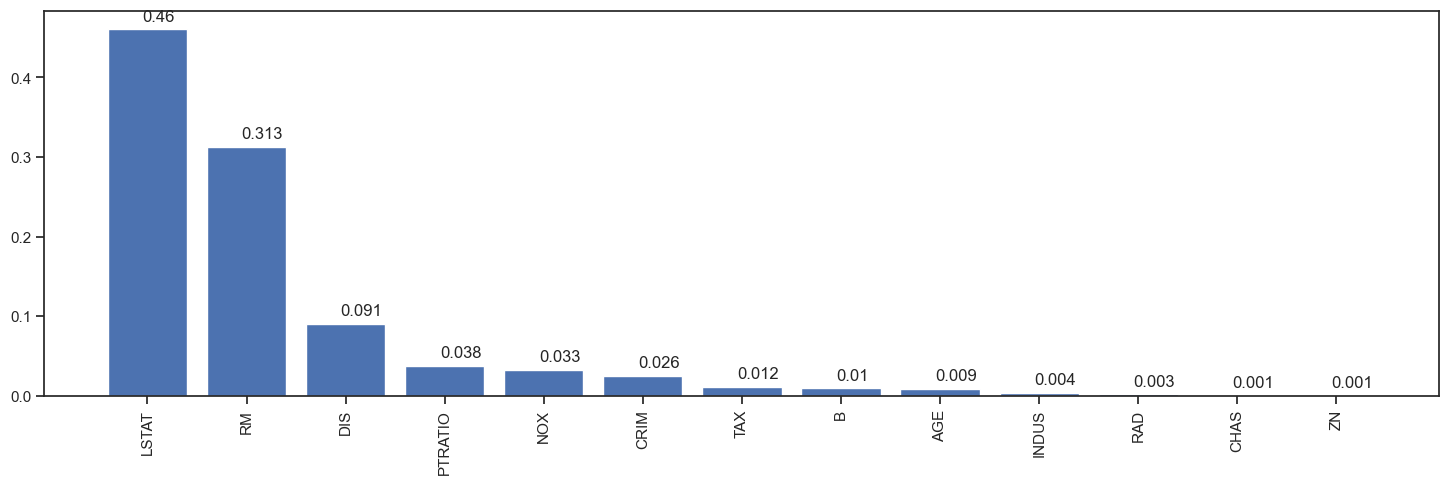

In [96]:
_,_ = draw_feature_importances(gb_reg, data_X)

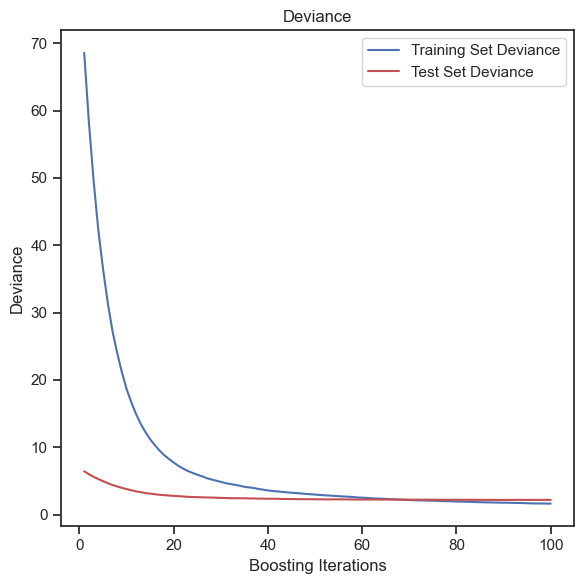

In [97]:
test_score = np.zeros((100,), dtype=np.float64)
for i, y_pred in enumerate(gb_reg.staged_predict(X_test)):
    test_score[i] = mean_absolute_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(100) + 1,
    gb_reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(100) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [101]:
for model in [gb_reg, svr_1]:
    test_model(model, X_test=X_train, y_test=y_train)

GradientBoostingRegressor(random_state=1)
mean_absolute_error: 0.9996715858787599
median_absolute_error: 0.7949373432613815
root_mean_squared_error: 1.2792742693557455
r2_score: 0.979741091861779
---------------------------------------
SVR(C=10, kernel='linear')
mean_absolute_error: 2.9914350851567373
median_absolute_error: 1.888566745984793
root_mean_squared_error: 4.973629299367904
r2_score: 0.6937786046364831
---------------------------------------


In [102]:
for model in [gb_reg, svr_1]:
    test_model(model, X_test=X_test, y_test=y_test)

GradientBoostingRegressor(random_state=1)
mean_absolute_error: 2.192555853798415
median_absolute_error: 1.6961866811533746
root_mean_squared_error: 2.845533653369505
r2_score: 0.9180686465943974
---------------------------------------
SVR(C=10, kernel='linear')
mean_absolute_error: 3.414980902547906
median_absolute_error: 2.435957219849719
root_mean_squared_error: 4.807649045178313
r2_score: 0.7661226359758129
---------------------------------------


### Вывод
Для оценки моделей, решающих задачу регрессии, использовались метрики MAE, RMSE, медианное абсолютное отклонение и R-квадрат

Модель градиентного бустинг по всем метрикам показала результаты лучше, чем машина опорных векторов